In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2022-11-25 17:02:56.060624: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 17:02:56.238738: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-25 17:02:57.019113: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.3/lib64
2022-11-25 17:02:57.019179: W tensorflow/compiler/xla/strea

1 Physical GPUs, 1 Logical GPUs


2022-11-25 17:02:58.005976: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 17:02:58.017573: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 17:02:58.018003: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 17:02:58.019065: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

In [2]:
import numpy as np
import pandas as pd
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import Sequential, models
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
path = './OX_images/'
dataset = {
    "image_path": [],
    "OX_status": [],
    "where": []
}

for where in os.listdir(path):
  for status in os.listdir(path+"/"+where):
    for image in glob.glob(path+where+"/"+status+"/"+"*.png"):
      dataset["image_path"].append(image)
      dataset["OX_status"].append(status)
      dataset["where"].append(where)

dataset = pd.DataFrame(dataset)
dataset.head()

,image_path,OX_status,where
0,./OX_images/test/O/o_9.png,O,test
1,./OX_images/test/O/o_5.png,O,test
2,./OX_images/test/O/o_2.png,O,test
3,./OX_images/test/O/o_6.png,O,test
4,./OX_images/test/X/x_2.png,X,test


With_O: 33
With_X: 33


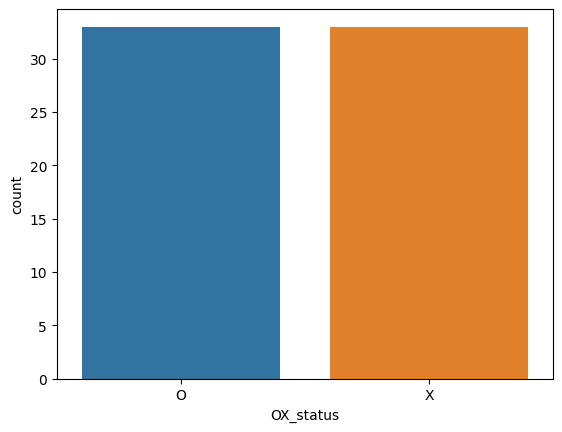

In [4]:
print(f"With_O:", dataset.value_counts("OX_status")[0])
print(f"With_X:", dataset.value_counts("OX_status")[1])

sns.countplot(x = dataset["OX_status"]);

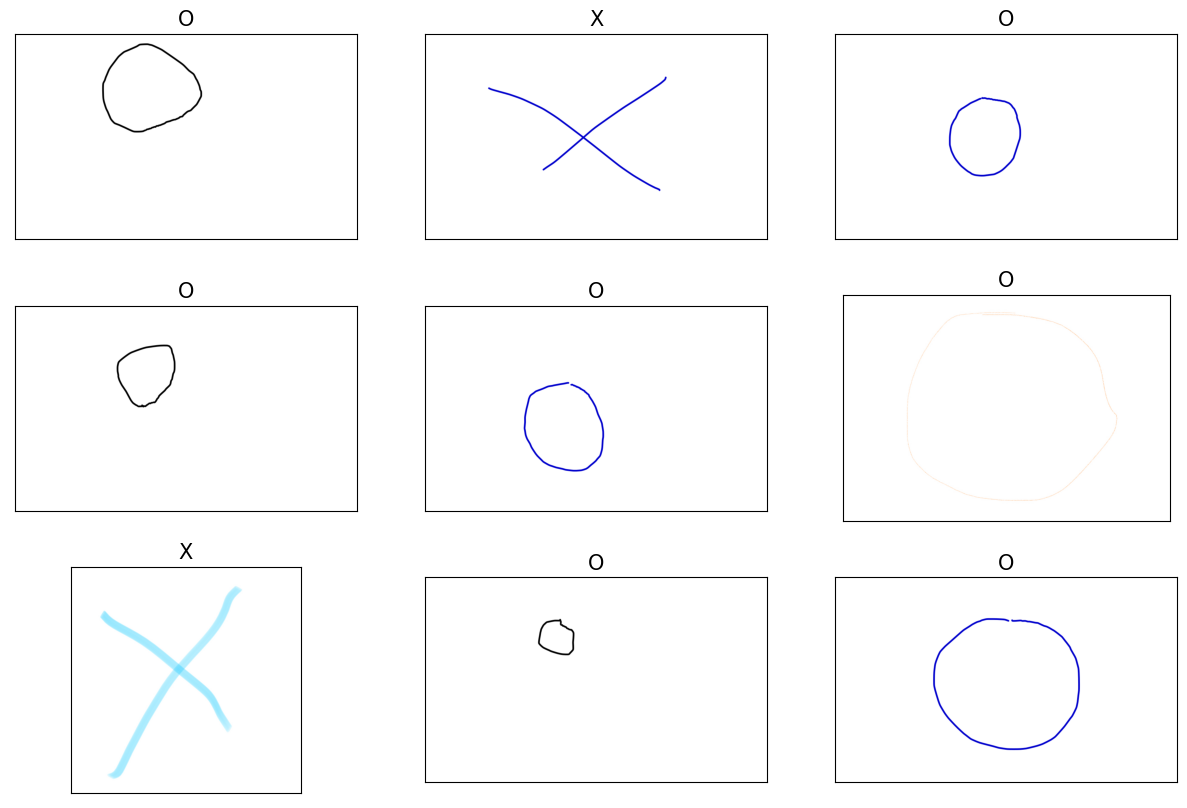

In [5]:
import cv2

plt.figure(figsize=(15, 10))

for i in range(9):
    random = np.random.randint(1, len(dataset))
    plt.subplot(3, 3, i+1)
    plt.imshow(cv2.imread(dataset.loc[random,"image_path"]))
    plt.title(dataset.loc[random,"OX_status"], size = 15)
    plt.xticks([])
    plt.yticks([])

plt.show()

In [6]:
train_df = dataset[dataset["where"] == "train"]
test_df = dataset[dataset["where"] == "test"]
valid_df = dataset[dataset["where"] == "validation"]

print(train_df.head(10))

                      image_path OX_status  where
28    ./OX_images/train/O/O2.png         O  train
29    ./OX_images/train/O/O3.png         O  train
30    ./OX_images/train/O/O5.png         O  train
31   ./OX_images/train/O/o_1.png         O  train
32   ./OX_images/train/O/O12.png         O  train
33   ./OX_images/train/O/O11.png         O  train
34    ./OX_images/train/O/O4.png         O  train
35  ./OX_images/train/O/o_10.png         O  train
36   ./OX_images/train/O/o_4.png         O  train
37   ./OX_images/train/O/O10.png         O  train


In [7]:
train_df = train_df.reset_index().drop("index", axis=1)
train_df.head()

,image_path,OX_status,where
0,./OX_images/train/O/O2.png,O,train
1,./OX_images/train/O/O3.png,O,train
2,./OX_images/train/O/O5.png,O,train
3,./OX_images/train/O/o_1.png,O,train
4,./OX_images/train/O/O12.png,O,train


In [8]:
data = []
image_size = 150

for i in range(len(train_df)):
    
    img_array = cv2.imread(train_df["image_path"][i], cv2.IMREAD_GRAYSCALE)

    new_image_array = cv2.resize(img_array, (image_size, image_size))

    if train_df["OX_status"][i] == "With_O":
        data.append([new_image_array, 1])
    else:
        data.append([new_image_array, 0])

In [9]:
type(data)

list

In [10]:
data = np.array(data)
type(data)

/tmp/ipykernel_31417/3133788812.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


numpy.ndarray

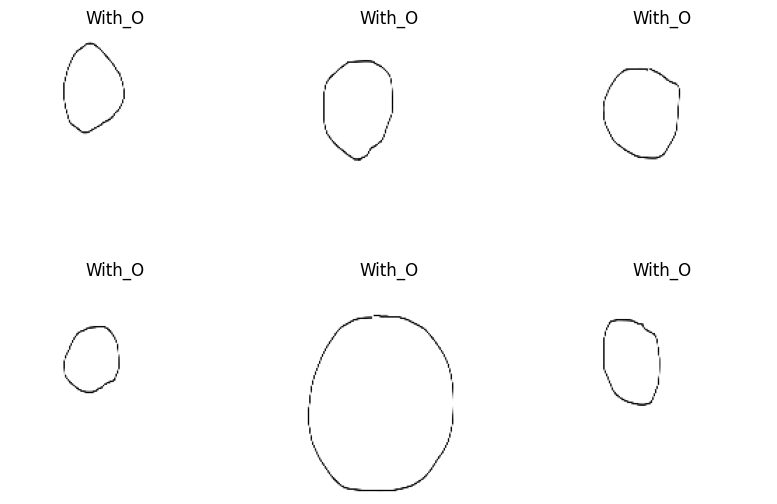

In [11]:
fig, ax = plt.subplots(2, 3, figsize=(10, 6))

for row in range(2):
    for col in range(3):
        image_index = row*10+col

        ax[row, col].axis("off")
        ax[row, col].imshow(data[image_index][0], cmap="gray")

        if data[image_index][1] == 0:
            ax[row, col].set_title("With_O")
        else:
            ax[row, col].set_title("With_X")

plt.show()

In [12]:
data[0]

array([array([[255, 255, 255, ..., 255, 255, 255],
              [255, 255, 255, ..., 255, 255, 255],
              [255, 255, 255, ..., 255, 255, 255],
              ...,
              [255, 255, 255, ..., 255, 255, 255],
              [255, 255, 255, ..., 255, 255, 255],
              [255, 255, 255, ..., 255, 255, 255]], dtype=uint8), 0],
      dtype=object)

In [13]:
X = []
y = []
 
for image in data:
    X.append(image[0])
    y.append(image[1])

X = np.array(X)
y = np.array(y)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

In [15]:
from tensorflow.keras import layers, models



In [16]:
model = models.Sequential([
                           layers.Conv2D(32, kernel_size=(5,5), strides=(1,1),
                                         padding='same', activation='relu', input_shape=(150,150,1)),
                           layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
                           layers.Conv2D(64, (2,2), activation='relu', padding='same'),
                           layers.MaxPooling2D(pool_size=(2,2)),
                           layers.Dropout(0.25),
                           layers.Flatten(),
                           layers.Dense(10, activation='relu'),
                           layers.Dense(1, activation='sigmoid')

])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 37, 37, 64)        0         
                                                                 
 flatten (Flatten)           (None, 87616)             0

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [18]:
X_train = X_train.reshape(len(X_train), X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(len(X_val), X_val.shape[1], X_val.shape[2], 1)

history = model.fit(X_train, y_train, epochs=100, batch_size = 2)

Epoch 1/100


2022-11-25 17:03:15.242548: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2022-11-25 17:03:16.902012: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8201
2022-11-25 17:03:21.175329: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-11-25 17:03:21.179420: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fcf892762b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-11-25 17:03:21.179517: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2022-11-25 17:03:21.186595: I tensorflow/compiler/mlir/tensorflow/utils/du

15/15 [==============================] - 10s 6ms/step - loss: 1.3427 - accuracy: 0.9333
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6/100
15/15 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 10/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - a

In [20]:
model.evaluate(X_val, y_val)

1/1 [==============================] - 0s 158ms/step - loss: 0.0000e+00 - accuracy: 1.0000


[0.0, 1.0]